## 1.1 Create a baseline model using a bag-of-words approach and a linear model.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 

In [5]:
test_df=pd.read_csv("reddit_200k_test.csv",usecols=['body','REMOVED'],engine='python')
train_df=pd.read_csv("reddit_200k_train.csv",usecols=['body','REMOVED'],engine='python')  

train_y=train_df["REMOVED"].replace(to_replace={True: 1,False:0}, value=None, method=None)
test_y=test_df["REMOVED"].replace(to_replace={True: 1,False:0}, value=None, method=None)

train_x=list(train_df["body"])
test_x=list(test_df["body"])

In [43]:
print("Postive examples:{}".format(train_df["REMOVED"].sum()))
print("Negative examples:{}".format(len(train_df["REMOVED"])-train_df["REMOVED"].sum()))

Postive examples:64738
Negative examples:102791


### Bags of words Baseline 

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(stop_words='english')
X_train_counts = count_vect.fit_transform(train_x)
X_test_counts= count_vect.transform(test_x)
print("X_train_counts:")
print(X_train_counts.shape)
print("X_test_counts:")
print(X_test_counts.shape)

train x:
(167529, 109821)
test x:
(55843, 109821)


In [62]:
list(count_vect.vocabulary_)[:20]

['ve',
 'taught',
 'emerged',
 'earth',
 'impace',
 'similar',
 'elemental',
 'distribution',
 'ece',
 'feeling',
 'hey',
 'thought',
 'times',
 'workers',
 'couldn',
 'write',
 'simple',
 'message',
 'communication',
 'book']

In [77]:
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
undersample_pipe_lr = make_imb_pipeline(CountVectorizer(stop_words='english'),RandomUnderSampler(), LogisticRegression())
scores = cross_validate(undersample_pipe_lr,
                        train_x, train_y, cv=10,
                        scoring=('roc_auc','accuracy','average_precision','recall','f1'))
print("-------test_roc_auc------\n"+str(scores['test_roc_auc'].mean()))
print("-------test_accuracy------\n"+str(scores['test_accuracy'].mean()))
print("-------test_average_precision------\n"+str(scores['test_average_precision'].mean()))
print("-------test_f1------\n"+str(scores['test_f1'].mean()))
print("-------recall------\n"+str(scores['test_recall'].mean()))

-------test_roc_auc------
0.7221142098110398
-------test_accuracy------
0.6494398116202424
-------test_average_precision------
0.5735917078855447
-------test_f1------
0.6195622928391454
-------recall------
0.738715939946073


In [88]:
## Tune Parameters
from sklearn.model_selection import GridSearchCV
parameters = {}
param_grid = {'countvectorizer__max_features': [10000,20000,30000,40000,50000]}
CV_lr = GridSearchCV(undersample_pipe_lr, param_grid, scoring = 'average_precision',cv=5)
CV_lr.fit(train_x, train_y)   
L=len(CV_lr.cv_results_['param_countvectorizer__max_features'])

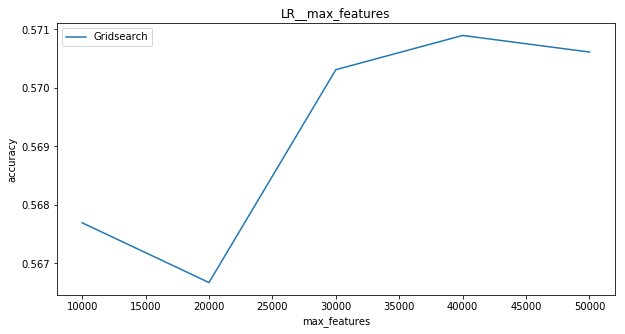

In [89]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(CV_lr.cv_results_['param_countvectorizer__max_features'].data, CV_lr.cv_results_ ["mean_test_score"],label="Gridsearch")
#plt.plot(CV_R.cv_results_["param_Ridge__alpha"].data,[0.863]*L,"red",label="base")
plt.title("LR__max_features")
plt.xlabel("max_features")
plt.ylabel("accuracy")
plt.legend()

### Comment:
Observing the plot above, we can see expanding the corpus does not help improve the performance of model idealy. To avoid overfitting, we will use 10000 as max_features.

In [90]:
scores = cross_validate(CV_lr.best_estimator_,
                        train_x, train_y, cv=10,
                        scoring=('roc_auc','accuracy','average_precision','recall','f1'))
print("-------test_roc_auc------\n"+str(scores['test_roc_auc'].mean()))
print("-------test_accuracy------\n"+str(scores['test_accuracy'].mean()))
print("-------test_average_precision------\n"+str(scores['test_average_precision'].mean()))
print("-------test_f1------\n"+str(scores['test_f1'].mean()))
print("-------recall------\n"+str(scores['test_recall'].mean()))

-------test_roc_auc------
0.7210723877425687
-------test_accuracy------
0.6488787515770919
-------test_average_precision------
0.5724942012099795
-------test_f1------
0.6197322711647735
-------recall------
0.7404152277985011


### 1.2 Try using n-grams, characters, tf-idf rescaling and possibly other ways to tune the BoW model. Be aware that you might need to adjust the (regularization of the) linear model for different feature sets.

### TFIDF 

In [91]:
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import cross_validate
undersample_pipe_lr = make_imb_pipeline(CountVectorizer(stop_words='english',max_features=10000),TfidfTransformer(),RandomUnderSampler(),LogisticRegression())
scores = cross_validate(undersample_pipe_lr,
                        train_x, train_y, cv=10,
                        scoring=('roc_auc','accuracy','average_precision','recall','f1'))
print("-------test_roc_auc------\n"+str(scores['test_roc_auc'].mean()))
print("-------test_accuracy------\n"+str(scores['test_accuracy'].mean()))
print("-------test_average_precision------\n"+str(scores['test_average_precision'].mean()))
print("-------test_f1------\n"+str(scores['test_f1'].mean()))
print("-------recall------\n"+str(scores['test_recall'].mean()))

-------test_roc_auc------
0.7480764869600759
-------test_accuracy------
0.6724865730406507
-------test_average_precision------
0.6206092423240731
-------test_f1------
0.6308598586187766
-------recall------
0.7242113709087737


### n-grams

In [93]:
undersample_pipe_lr = make_imb_pipeline(CountVectorizer(stop_words='english',max_features=10000,ngram_range=(1,2)),RandomUnderSampler(),LogisticRegression())
scores = cross_validate(undersample_pipe_lr,
                        train_x, train_y, cv=10,
                        scoring=('roc_auc','accuracy','average_precision','recall','f1'))
print("-------test_roc_auc------\n"+str(scores['test_roc_auc'].mean()))
print("-------test_accuracy------\n"+str(scores['test_accuracy'].mean()))
print("-------test_average_precision------\n"+str(scores['test_average_precision'].mean()))
print("-------test_f1------\n"+str(scores['test_f1'].mean()))
print("-------recall------\n"+str(scores['test_recall'].mean()))

-------test_roc_auc------
0.7183838661616452
-------test_accuracy------
0.6446346881910389
-------test_average_precision------
0.5677638957388668
-------test_f1------
0.6201268273285395
-------recall------
0.7506100409672058


### character